In [2]:
%load_ext autoreload
%autoreload 2
import enum
import os
from weakref import ref
import pandas as pd 
import openpyxl
import numpy as np
import re
from collections import deque, defaultdict, OrderedDict
from unicodedata import normalize
import itertools
import math
import seaborn as sns
import torch
from data_interpolation import read_excel_file, build_out_file, group_df_data_by_car, get_training_inputs
from kde_model import KDENet,  train, build_df
import numpy as np
import japanize_matplotlib
import random
import torch 
from torch import nn
import torch.nn.functional as F
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'IPAexGothic'
import japanize_matplotlib

Text(0.5, 1.0, 'トヨタ')

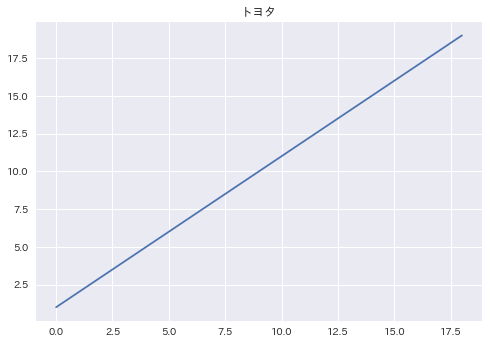

In [3]:
plt.plot(range(1, 20),)
plt.title('トヨタ')


In [4]:
target_max = {'CO2排出量(g-CO2/km)_old': 500., "走行距離(km)_old": 12000.}
masks = {'走行距離(km)': 'distance_mask', 'CO2排出量(g-CO2/km)':'co2_mask'}

In [5]:
def read_excel_file(filename) ->pd.DataFrame:
    names = ['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)']
    # TODO
    # names = ['燃費_平均値(平均)', '燃費_平均値(中央)', ]
    dfs = dict()
    # for sheet in list(map(lambda co2_name: f'最終的に求めたいバックデータ形式({co2_name})補正',
    for sheet in list(map(lambda co2_name:   f'最終的に求めたいバックデータ形式({co2_name})',
                    names)):
        df = pd.read_excel(filename, sheet_name=sheet, skiprows=0) 
        top_cols = [col for col in df.columns if  'Unnamed' not in col]
        ref_col = None
        df.drop(columns=["Unnamed: 0"], inplace=True)
        columns = []
        for i, (n1, n2) in enumerate(df.iloc[0].items()):
            if "Unnamed" not in n1:
                ref_col = n1
            columns.append((ref_col, n2))
        df.columns = columns
        df = df.iloc[2:]
        dfs[sheet] = df.reset_index(drop=True)
    return dfs

# read_excel_file(os.path.join(model_dir, '最終的に欲しいバックデータ形式_230302処理結果-v1-補正.xlsx'))

In [6]:
def get_out_df(filename):
    dfs = read_excel_file(filename)
    res_df = dict()
    for sheet, df in dfs.items():
        df = df.copy(deep=True)
        out_df = build_out_file(df)
        df2 = df.set_index([( '走行距離(km)', 'メーカー'), 
                            ( '走行距離(km)', 'ボディタイプ'),
                ])
        
        df2.index.set_names([ 'メーカー', 'ボディタイプ'], inplace=True)

        for training_col in ["走行距離(km)_old", 'CO2排出量(g-CO2/km)_old']:
            res_df[f"{training_col[:5]} - {sheet}"] = df2.copy()

    return res_df
          

In [68]:
SIM_DIR = "/home/barry/projects/nexco/toyota/data/MASTER_03/simulation_multi"
model_dir = os.path.join(SIM_DIR, "model_10-1.0-20")
# res_df = get_out_df(os.path.join(model_dir, '最終的に欲しいバックデータ形式_230302処理結果-v4-補正.xlsx'))
res_df = get_out_df(os.path.join(model_dir, '最終的に欲しいバックデータ形式_230310処理結果-v1-補正.xlsx'))

[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask', 'メーカー'), ('co2_mask', 'ボディタイプ')]
[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask', 'メーカー'), ('co2_mask', 'ボディタイプ')]
[('CO2排出量(g-CO2/km)', 'メーカー'), ('CO2排出量(g-CO2/km)', 'ボディタイプ'), ('合計 /  SUM(台数)', 'メーカー'), ('合計 /  SUM(台数)', 'ボディタイプ'), ('走行距離(km)_old', 'メーカー'), ('走行距離(km)_old', 'ボディタイプ'), ('CO2排出量(g-CO2/km)_old', 'メーカー'), ('CO2排出量(g-CO2/km)_old', 'ボディタイプ'), ('distance_mask', 'メーカー'), ('distance_mask', 'ボディタイプ'), ('co2_mask'

In [69]:
def analysis_by_agg_car_type(dfs,):
    skip_columns =['電気', '燃料電池',]
    def run(df, co2_flag):
        X_train, X_valid = defaultdict(list), defaultdict(list)
        index = np.array(df.index.tolist())
        body_types = np.unique(index[:, 1])
        car_types =  np.unique(index[:, 0])
        engine_types = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']

        for ct in car_types:
            _df = df.query(f"メーカー == '{ct}'").copy()
            col_name = '走行距離(km)' if not co2_flag else 'CO2排出量(g-CO2/km)'
            mask_name = {'走行距離(km)': "distance_mask", 'CO2排出量(g-CO2/km)': "co2_mask",}[col_name]
            for eng_type in engine_types:
                if eng_type in skip_columns:
                    continue
                for i in range(len(_df)):
                    row = _df.iloc[i]
                    if row[(mask_name, eng_type)] == 2:
                        X_train[ct].append(row[(col_name, eng_type)])
                    else:
                        X_valid[ct].append(row[(col_name, eng_type)])

        return {'train': X_train, 'valid': X_valid}

    res = {}

    for key, df in dfs.items():
        res[key] = run(df, co2_flag=key.startswith('CO2排出'))
    return res

In [70]:
res_car_types_preds = analysis_by_agg_car_type(res_df)

In [71]:
def plot_analysis_by_agg_car_type(res_q, dfs, savefolder, space=1.2):

    def run(df, co2_flag):
        X_train, X_valid = defaultdict(list), defaultdict(list)
        index = np.array(df.index.tolist())
        body_types = np.unique(index[:, 1])
        car_types =  np.unique(index[:, 0])
        engine_types = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']
    
    
    res = {}
    random.seed(20)
    colors = list(map(lambda x: str(x) , list(range(0, 10)))) + ["A", "B", "C", "D", "E", "F"]
    color = [ "#" + "".join([random.choice(colors) for _ in range(6)]) for __ in range(100)][::3]
    for key, q in res_q.items():
        # res[key] = run(df, co2_flag=key.startswith('CO2排出'))
        col_name = '走行距離(km)' if not key.startswith('CO2排出') else 'CO2排出量(g-CO2/km)'
        fig, ax=plt.subplots(figsize=(15, 7))
        cars = list(q['valid'].keys())
        errors = []
        errs = []

        for j, car in enumerate(cars):
            # if car in q['train']:
            val = 1 + random.uniform(-3, 3)
            ax.scatter(np.mean(q['train'][car]),
                        val, 
                        label=car,
                        marker="*",
                        color=color[j])
            ax.scatter(np.mean(q['valid'][car]),
                        val,
                        label=car,
                        marker="o",
                        color=color[j])
            error = math.fabs((np.mean(q['valid'][car]) - np.mean(q['train'][car])) * 100. / (np.mean(q['valid'][car]) + 1e-9))
            # ax.text(np.mean(q['valid'][car]) + 2.0,
            #         val, f"{error} %",
            #             # label=car,
            #             )
            # print(error)
            
            errors.append(np.round(error, 3))
            if np.isnan(errors[-1]):
                errors[-1] = 0.0
                continue
            errs.append(errors[-1])

        title = re.sub(r'\( - 最終的に求めたいバックデータ形式', '' , key)
        title = re.sub(r'- 最終的に求めたいバックデータ形式', '' , key)
        ax.set_title(title)
        ax.set_xlabel(title[:5])
        h, l = ax.get_legend_handles_labels()
        labels = []
        handles = []
        dups = set()
        for k, s in enumerate(l):
            if s in dups:
                continue
            dups.add(s)
            labels.append(f'{s} - {errors[int(k / 2)]}%')
            handles.append(h[k])
        ax.legend(handles=handles ,labels=labels, bbox_to_anchor=(space, 1), loc='upper right',)
        plt.tight_layout()
        os.makedirs(savefolder, exist_ok=True)
        plt.savefig(os.path.join(savefolder, f'{title}.png'))
        print(title, np.mean(errs))

    print(np.mean(errs))
    # return res



In [72]:
def analysis_by_agg_body_type(dfs,):
    skip_columns =['電気', '燃料電池',]
    def run(df, co2_flag):
        X_train, X_valid = defaultdict(list), defaultdict(list)
        index = np.array(df.index.tolist())
        body_types = np.unique(index[:, 1])
        car_types =  np.unique(index[:, 0])
        engine_types = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']

        for ct in body_types:
            _df = df.query(f"ボディタイプ == '{ct}'").copy()
            col_name = '走行距離(km)' if not co2_flag else 'CO2排出量(g-CO2/km)'
            mask_name = {'走行距離(km)': "distance_mask", 'CO2排出量(g-CO2/km)': "co2_mask",}[col_name]
            for eng_type in engine_types:
                if eng_type in skip_columns:
                    continue
                for i in range(len(_df)):
                    row = _df.iloc[i]
                    if row[(mask_name, eng_type)] == 2:
                        X_train[ct].append(row[(col_name, eng_type)])
                    else:
                        X_valid[ct].append(row[(col_name, eng_type)])
        return {'train': X_train, 'valid': X_valid}

    res = {}
    for key, df in dfs.items():
        res[key] = run(df, co2_flag=key.startswith('CO2排出'))
    return res

In [73]:
res_body_types_preds  = analysis_by_agg_body_type(res_df)

In [74]:
def analysis_by_agg_engine_type(dfs,):
    # skip_columns =['電気', '燃料電池',]
    def run(df, co2_flag):
        X_train, X_valid = defaultdict(list), defaultdict(list)
        index = np.array(df.index.tolist())
        body_types = np.unique(index[:, 1])
        car_types =  np.unique(index[:, 0])
        engine_types = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']

        for ct in body_types:
            _df = df.query(f"ボディタイプ == '{ct}'").copy()
            col_name = '走行距離(km)' if not co2_flag else 'CO2排出量(g-CO2/km)'
            mask_name = {'走行距離(km)': "distance_mask", 'CO2排出量(g-CO2/km)': "co2_mask",}[col_name]
            for eng_type in engine_types:
                for i in range(len(_df)):
                    row = _df.iloc[i]
                    if row[(mask_name, eng_type)] == 2:
                        X_train[eng_type].append(row[(col_name, eng_type)])
                    else:
                        X_valid[eng_type].append(row[(col_name, eng_type)])
        return {'train': X_train, 'valid': X_valid}
    res = {}
    for key, df in dfs.items():
        res[key] = run(df, co2_flag=key.startswith('CO2排出'))
    return res


In [75]:
res_engine_types_preds  = analysis_by_agg_engine_type(res_df)

走行距離( (燃費_平均値(平均)) 9.290176470588236


/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/barry/projects/bai/bai_backend/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CO2排出 (燃費_平均値(平均)) 11.790571428571427
走行距離( (燃費_平均値(中央)) 9.290176470588236
CO2排出 (燃費_平均値(中央)) 12.211071428571428
走行距離( (燃費_中央値(平均)) 9.290176470588236
CO2排出 (燃費_中央値(平均)) 12.207785714285716
走行距離( (燃費_中央値(中央)) 9.290176470588236
CO2排出 (燃費_中央値(中央)) 12.944999999999999
12.944999999999999


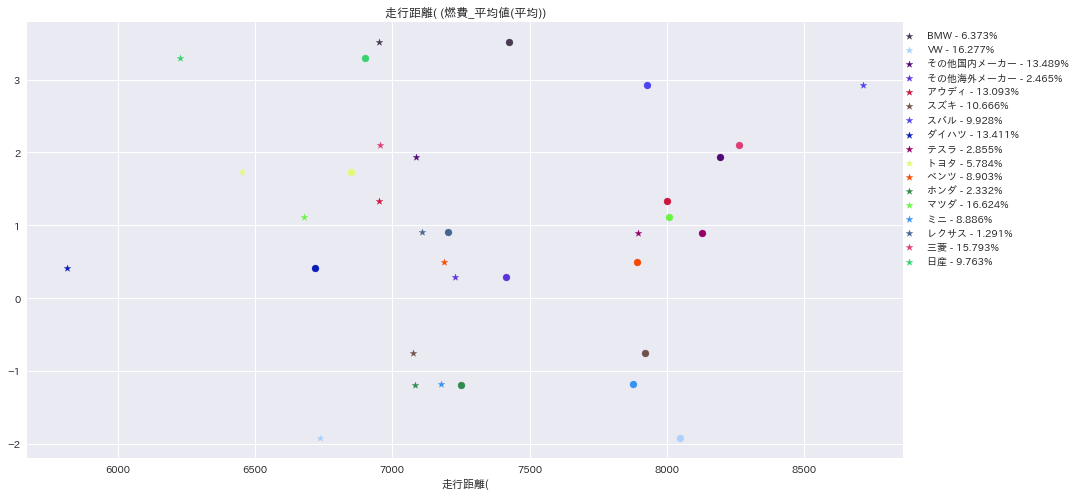

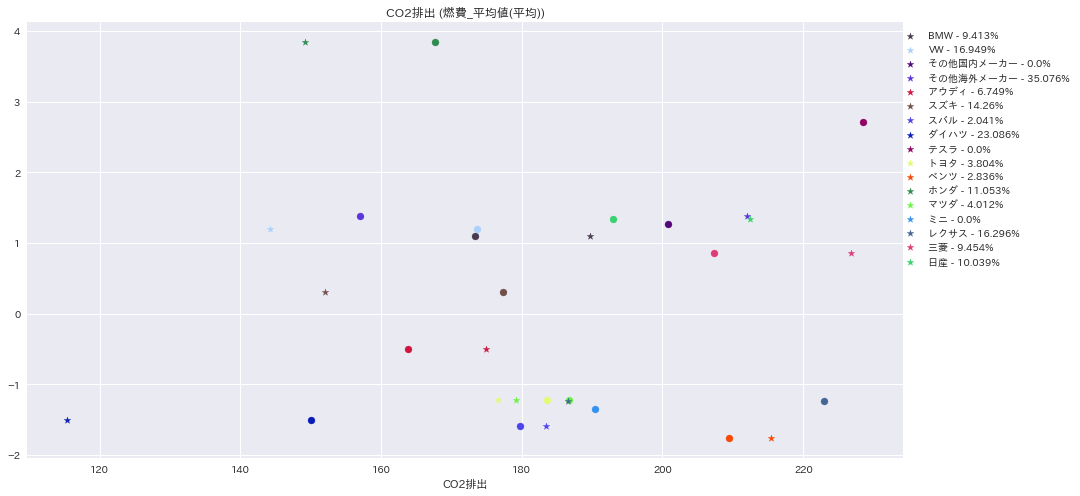

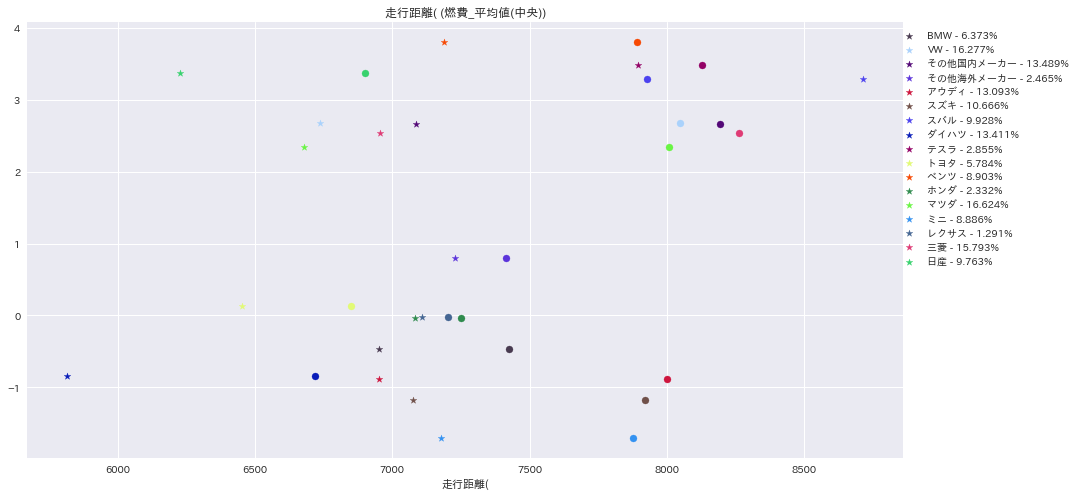

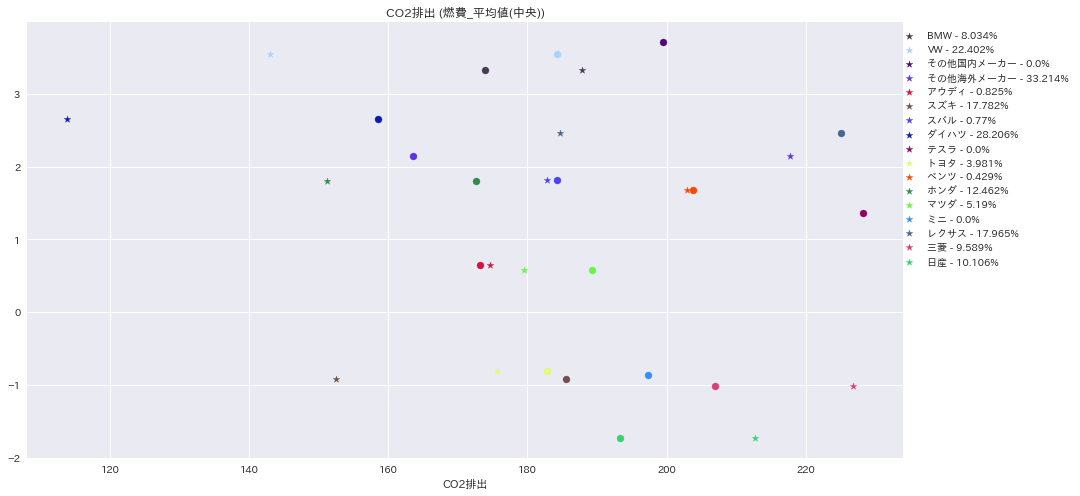

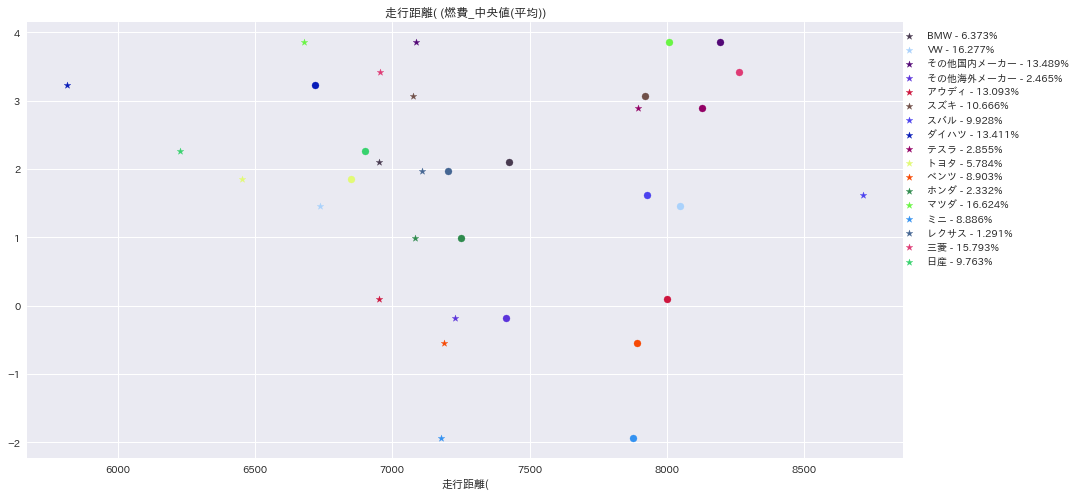

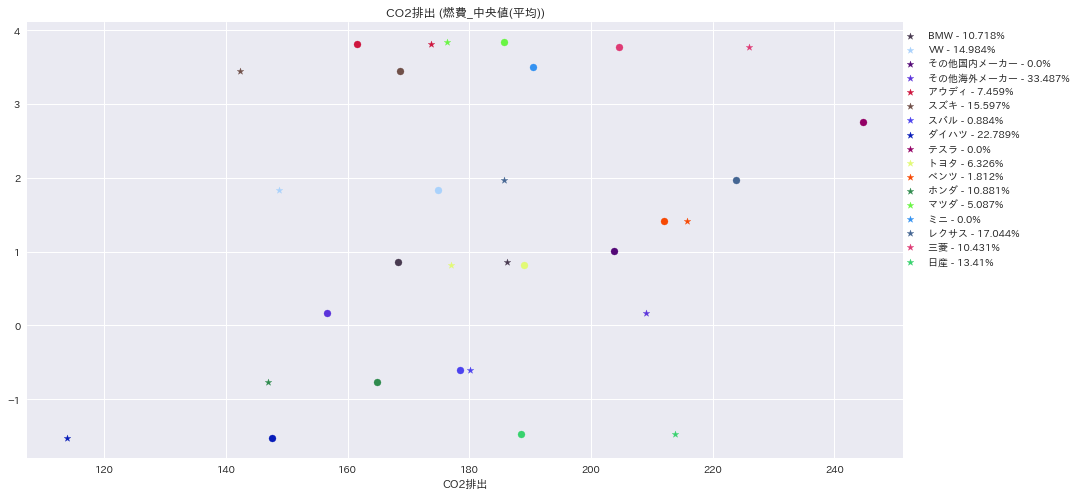

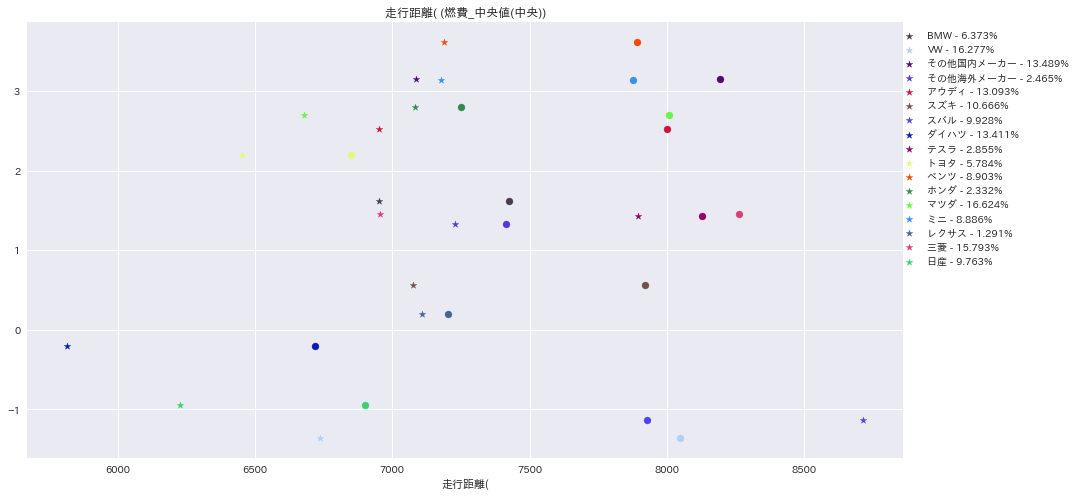

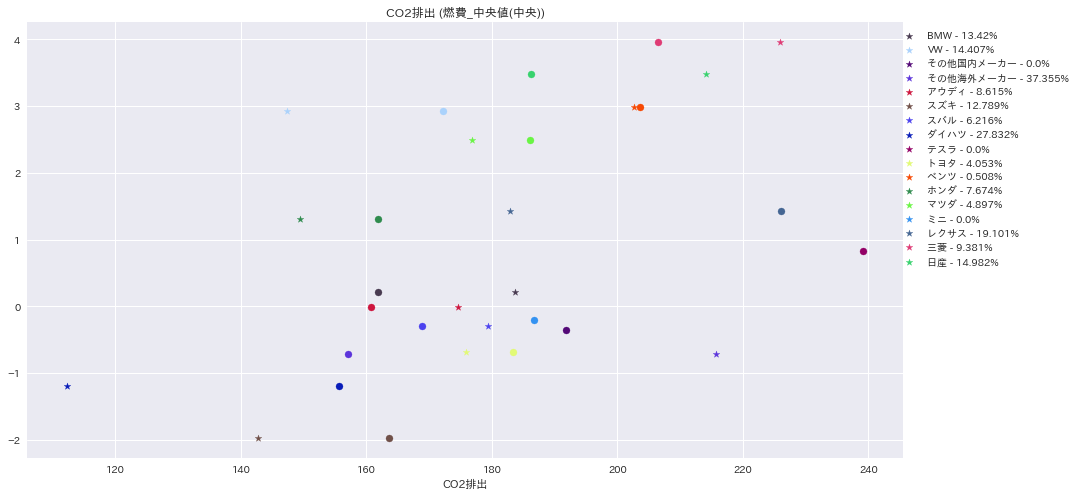

In [76]:
plot_analysis_by_agg_car_type(res_car_types_preds, res_df, savefolder="/home/barry/projects/nexco/toyota/data/MASTER_03/2023-03-09/cars")

走行距離( (燃費_平均値(平均)) 9.20484
CO2排出 (燃費_平均値(平均)) 7.625
走行距離( (燃費_平均値(中央)) 9.20484
CO2排出 (燃費_平均値(中央)) 7.114208333333333
走行距離( (燃費_中央値(平均)) 9.20484
CO2排出 (燃費_中央値(平均)) 7.467125
走行距離( (燃費_中央値(中央)) 9.20484
CO2排出 (燃費_中央値(中央)) 7.831125
7.831125


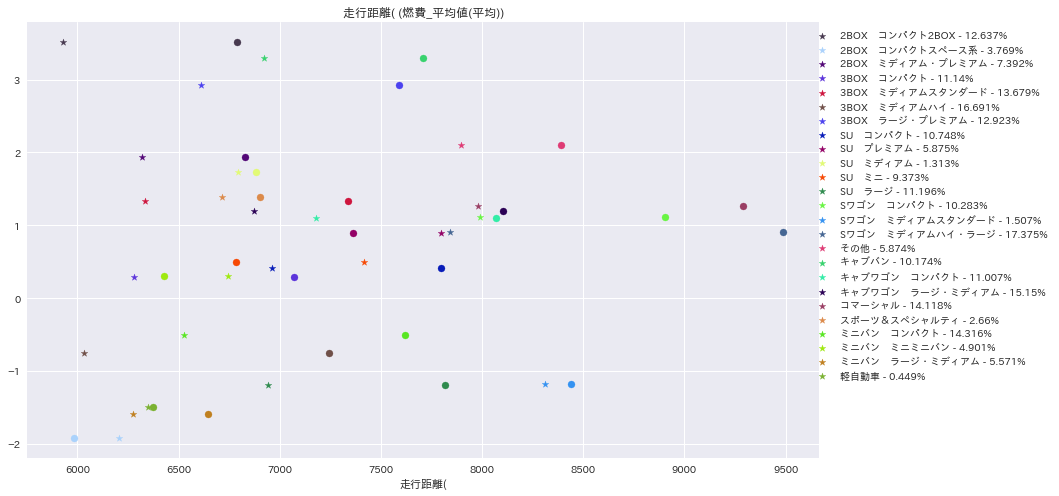

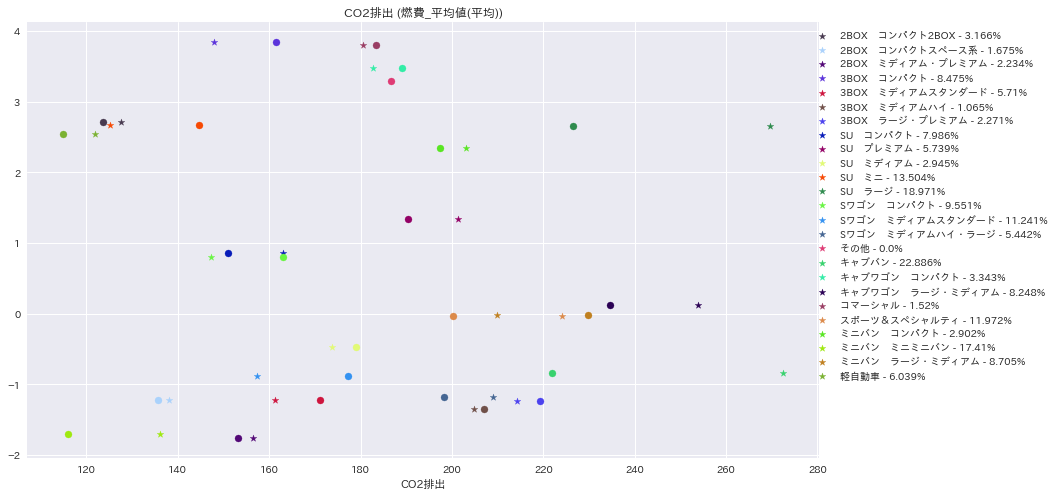

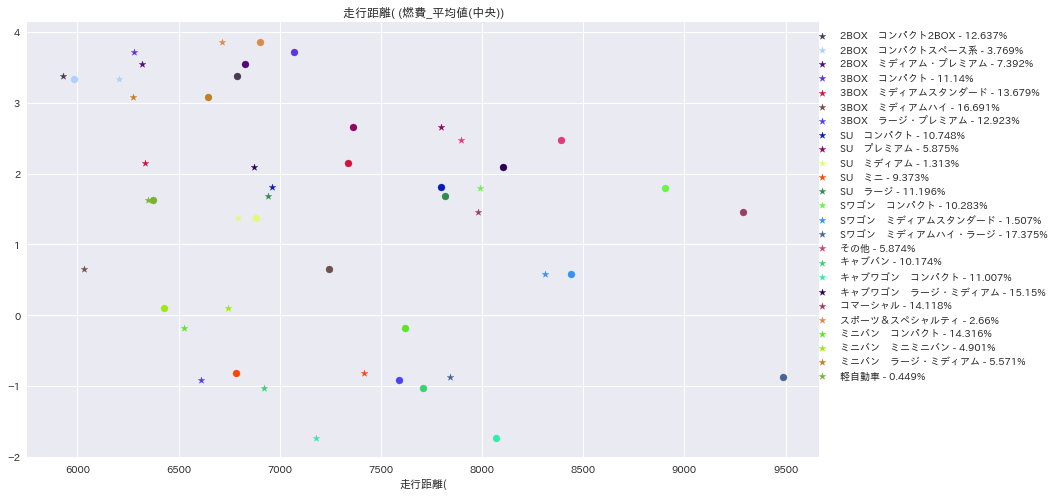

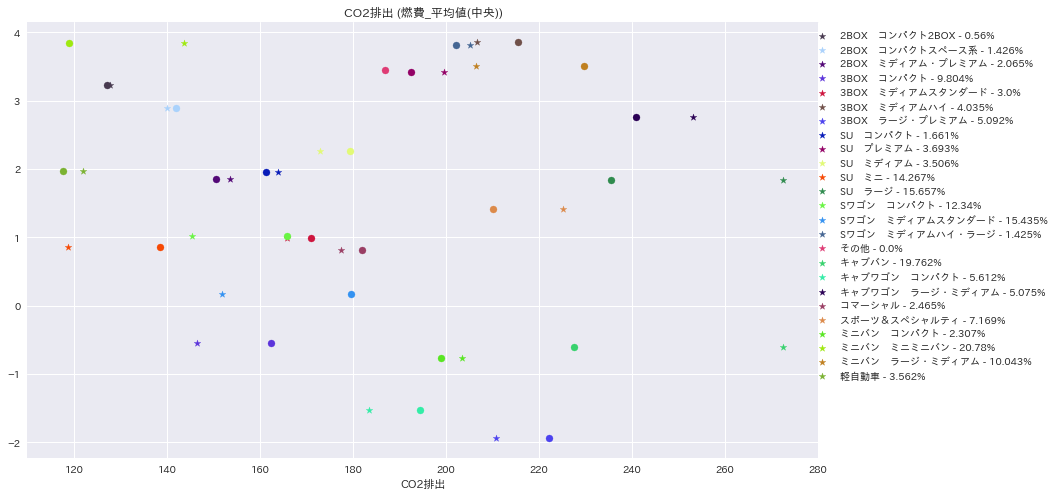

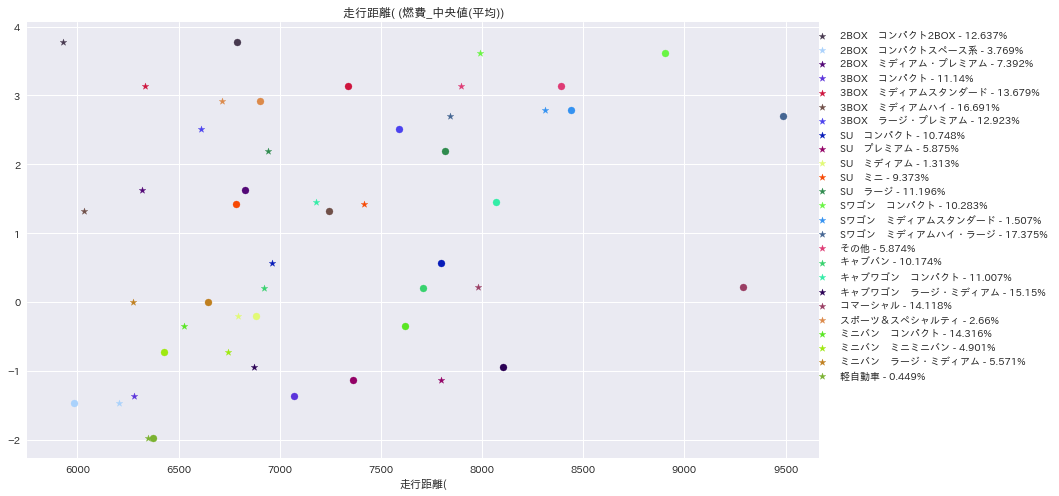

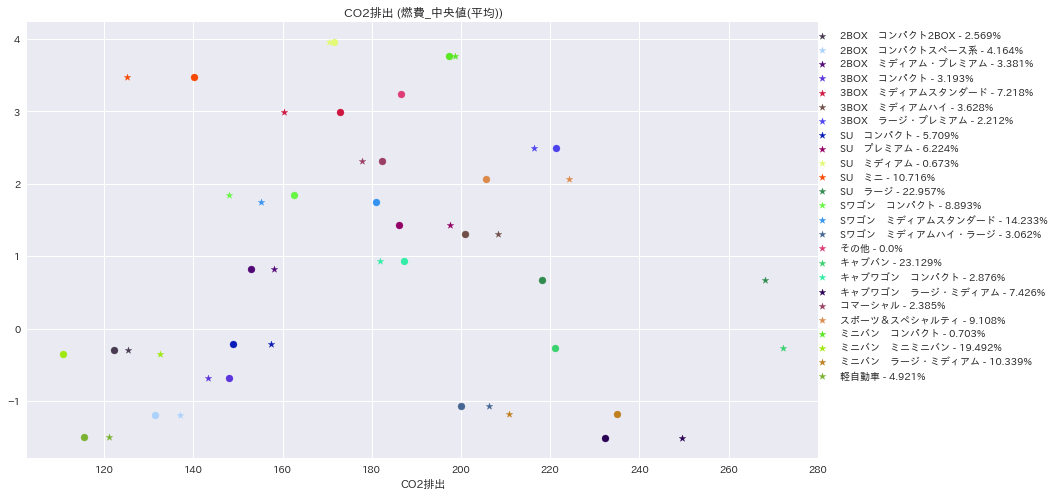

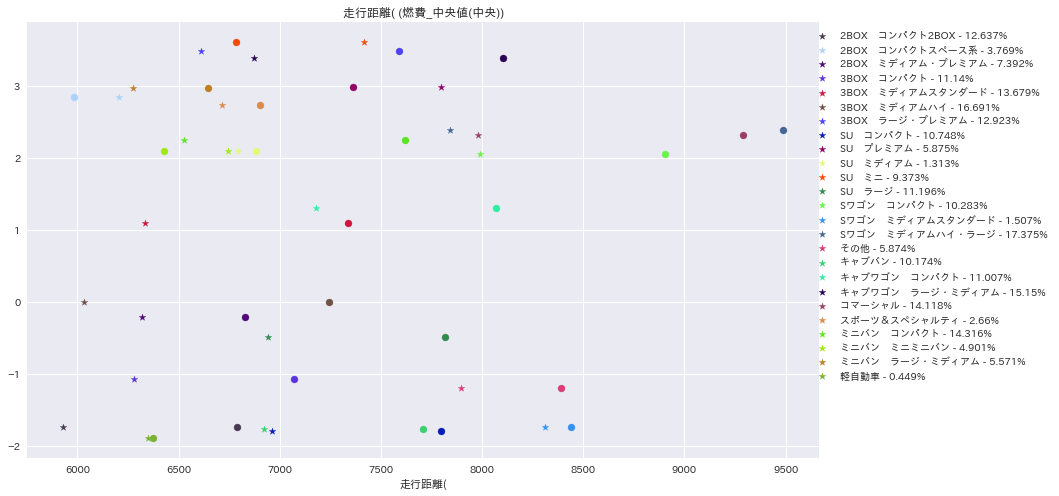

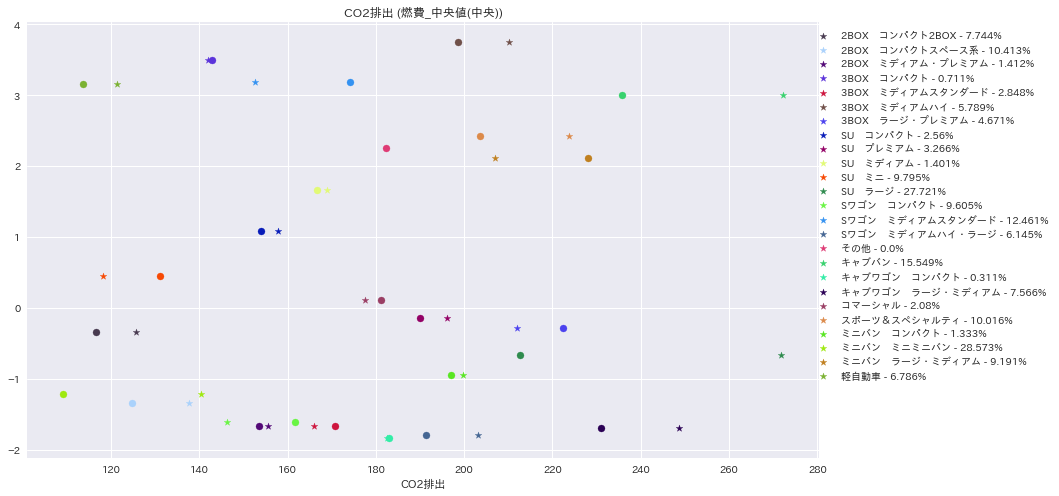

In [77]:
plot_analysis_by_agg_car_type(res_body_types_preds, res_df, savefolder="/home/barry/projects/nexco/toyota/data/MASTER_03/2023-03-09/bodies", space=1.3)

走行距離( (燃費_平均値(平均)) 7.746833333333334
CO2排出 (燃費_平均値(平均)) 13.405666666666669
走行距離( (燃費_平均値(中央)) 7.746833333333334
CO2排出 (燃費_平均値(中央)) 13.749666666666664
走行距離( (燃費_中央値(平均)) 7.746833333333334
CO2排出 (燃費_中央値(平均)) 13.327166666666669
走行距離( (燃費_中央値(中央)) 7.746833333333334
CO2排出 (燃費_中央値(中央)) 13.458833333333333
13.458833333333333


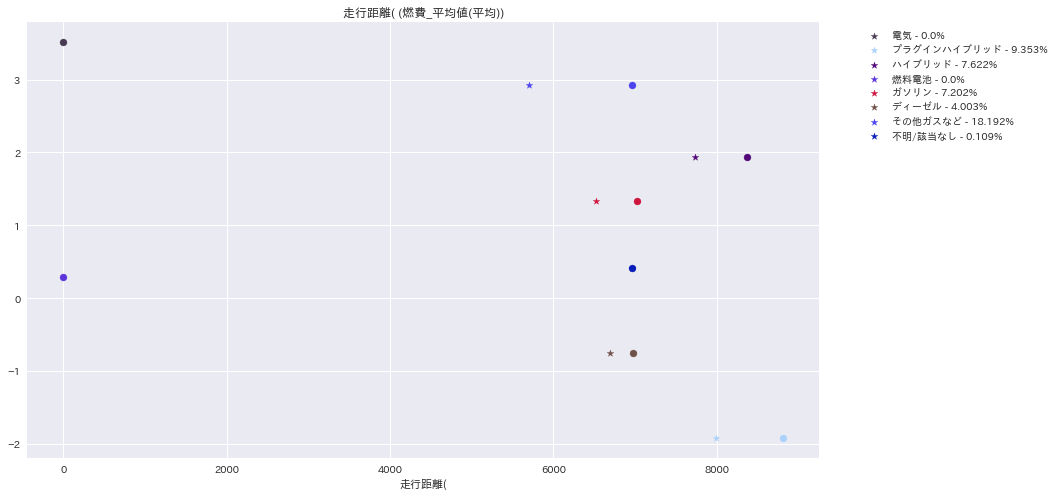

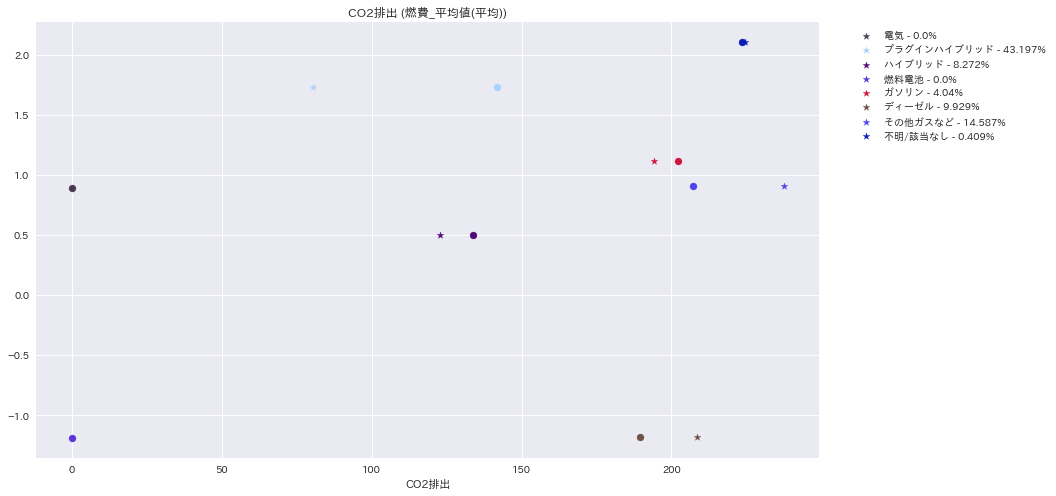

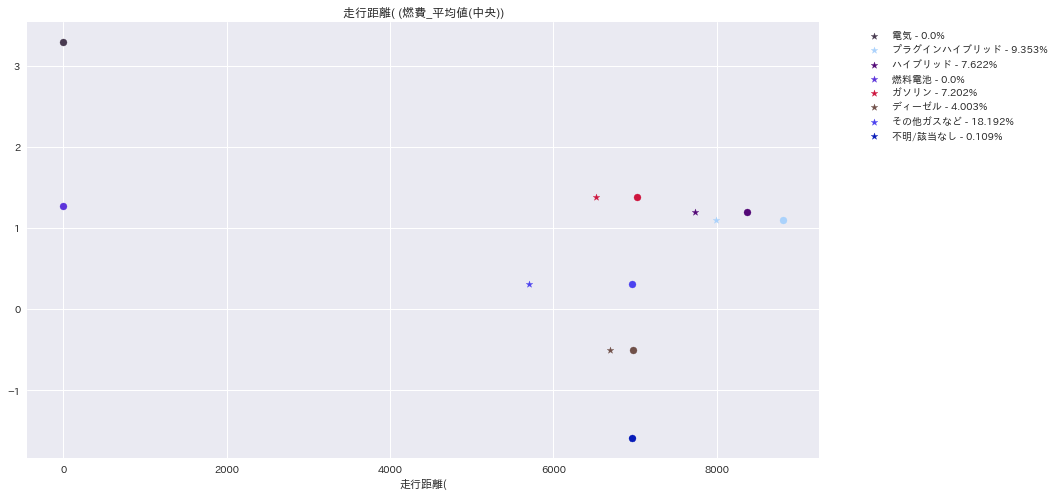

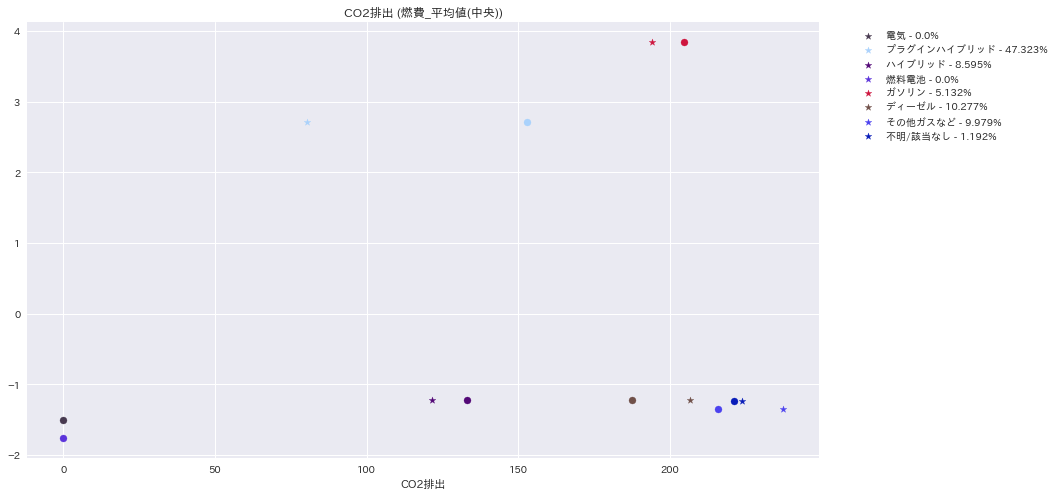

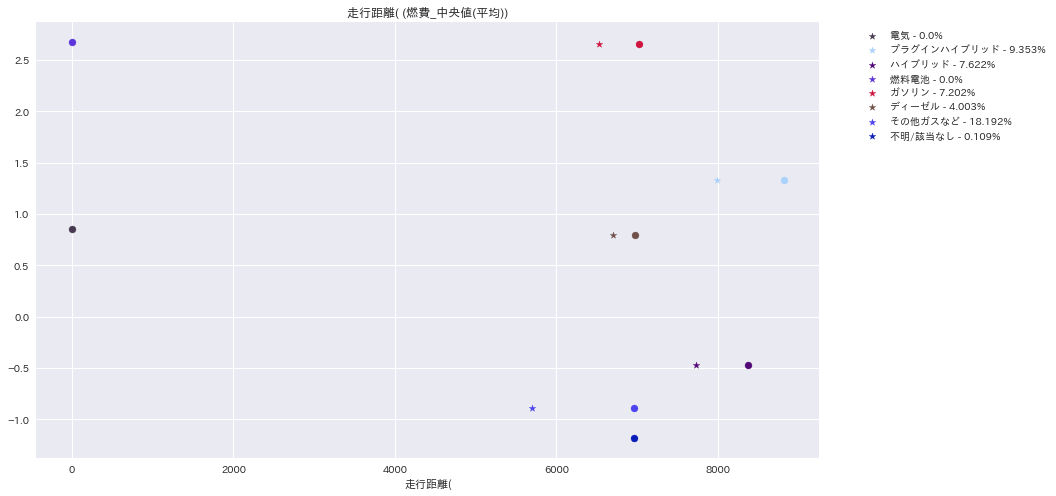

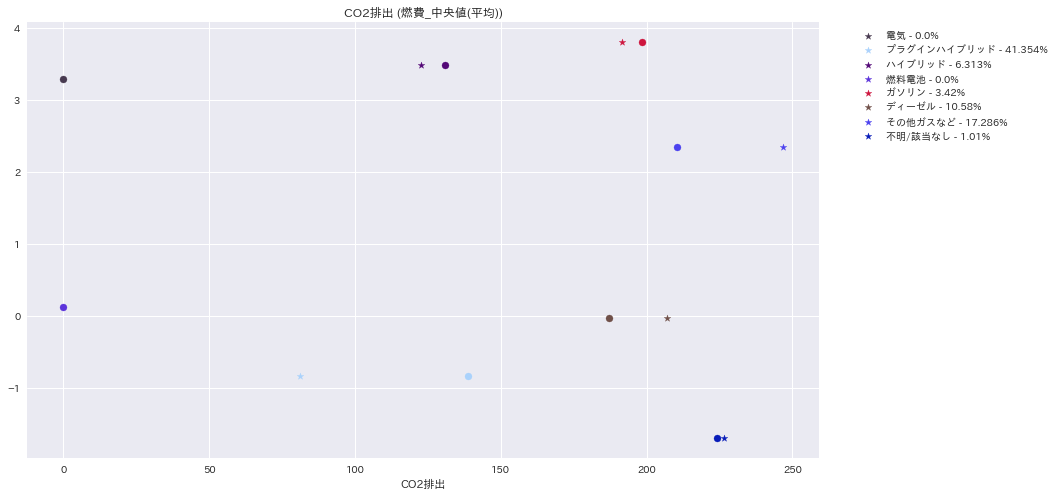

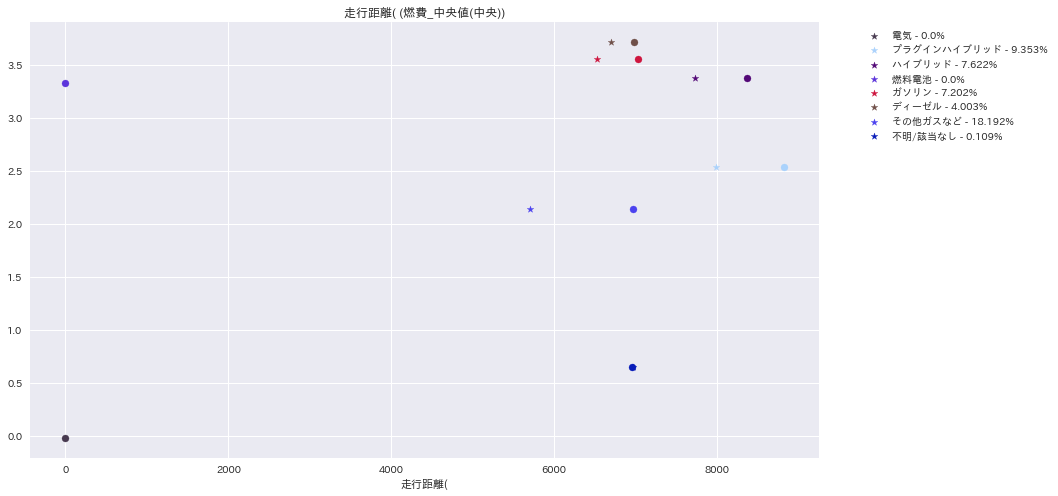

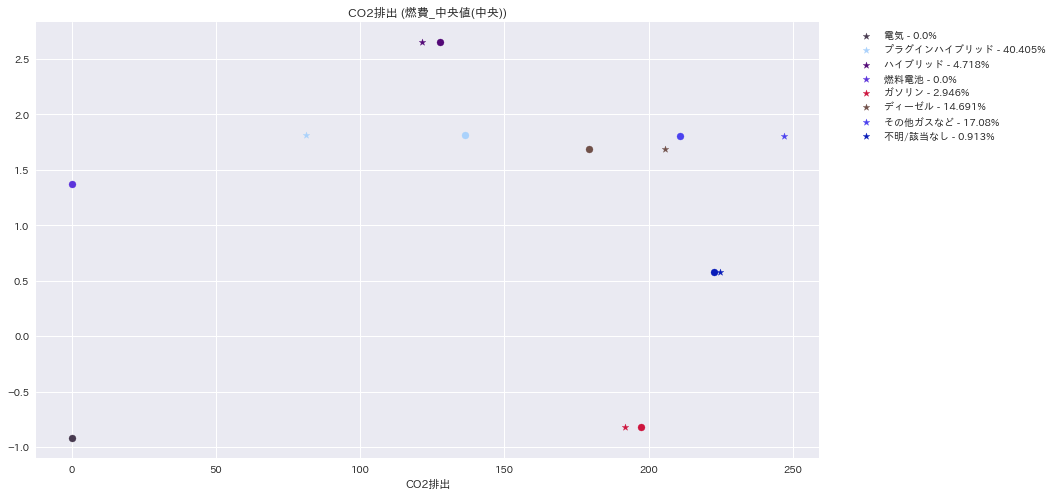

In [78]:
plot_analysis_by_agg_car_type(res_engine_types_preds, res_df, savefolder="/home/barry/projects/nexco/toyota/data/MASTER_03/2023-03-09/engines", space=1.3)

In [79]:

def save_file(df, new_filename, sheet):
    try:
        with pd.ExcelWriter(new_filename, engine='openpyxl', mode='a') as writer: 
            df.to_excel(writer, sheet_name=f'{sheet}')
    except:
        with pd.ExcelWriter(new_filename, engine='openpyxl', mode='w') as writer: 
            df.to_excel(writer, sheet_name=f'{sheet}')


def get_sim_files(res_dfs):
    # dfs = read_excel_file(filename)
    interp_types = {"走行距離( - ": '走行距離(km)', 
                    "CO2排出 - ":  'CO2排出量(g-CO2/km)'
                    }
    sheets = ['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)']
    # sheets = ['燃費_平均値(平均)', '燃費_平均値(中央)']
    engines_columns = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']

    for sheet in sheets:
        print(sheet)
        dst_df, co2_df = res_dfs[f'走行距離( - 最終的に求めたいバックデータ形式({sheet})補正'].copy(), \
            res_dfs[f'CO2排出 - 最終的に求めたいバックデータ形式({sheet})補正'].copy()
        
        bodies = [x[1] for x in dst_df.index.values]
        cars = [x[0] for x in dst_df.index.values]
       
        dst_df = dst_df.reset_index()
        dst_df['body_type'] = dst_df.loc[:, 'ボディタイプ'].apply(lambda x: x.split()[0])
        dst_df['count'] = 1   

        columns = list(itertools.product(['走行距離(km)', 'CO2排出量(g-CO2/km)',  '合計 /  SUM(台数)'], engines_columns))
        mapper = {}


        for col in columns:
            op = sum if col[0] == '合計 /  SUM(台数)' else "mean"
            mapper[col] = op
        mapper[ 'count'] = sum

        res_df = dst_df.groupby(['メーカー', 'body_type']).agg(mapper).reset_index()
        res_df['ボディタイプ'] = [ bodies[i] if res_df['count'][i] < 2 else f"{el}計"  
                                for i, el in enumerate(res_df['body_type'])
                                ]
        res_df.drop(columns=['count'], inplace=True)
        res_df = res_df[["メーカー", 'ボディタイプ'] + columns]

        res_df.set_index(["メーカー", 'ボディタイプ'], inplace=True)
        res_df.columns =pd.MultiIndex.from_tuples(res_df.columns)
        res_df.reset_index(inplace=True)
        
        save_file(res_df, './data/MASTER/2023-03-06/最終的に欲しいバックデータ形式_230306_｟メーカーｘカテゴリ｠-v4.xlsx', f"最終的に求めたいバックデータ形式({sheet})補正")


        res_df = dst_df.groupby(['メーカー']).agg(mapper).reset_index()
      
        res_df.drop(columns=['count'], inplace=True)

        res_df = res_df[["メーカー"] + columns]

        res_df.set_index(["メーカー"], inplace=True)
        res_df.columns =pd.MultiIndex.from_tuples(res_df.columns)
        save_file(res_df, './data/MASTER/2023-03-06/最終的に欲しいバックデータ形式_230306_｟メーカー｠-v4.xlsx', f"最終的に求めたいバックデータ形式({sheet})補正")
            
        
        

        
# dst_df= get_sim_files(res_df)

In [ ]:
dst_df.columns =pd.MultiIndex.from_tuples(dst_df.columns)

In [ ]:
dst_df["走行距離(km)"]

電気   プラグインハイブリッド       ハイブリッド  燃料電池         ガソリン        ディーゼル  \
メーカー                                                                        
BMW        0.0   8203.237777  7113.873326   0.0  6626.789255  6855.932252   
VW         0.0   9650.486694  8376.559570   0.0  7069.497558  7407.948364   
その他国内メーカー  0.0   8590.942560  8232.044300   0.0  7026.768216  7049.352821   
その他海外メーカー  0.0   8387.751457  8271.703852   0.0  6940.213805  6971.332752   
アウディ       0.0   8840.866862  7960.333884   0.0  7036.553855  7463.125306   
スズキ        0.0   9064.390340  8122.213679   0.0  7015.408744  7033.939310   
スバル        0.0   9374.014103  9127.116584   0.0  7454.911299  7463.926262   
ダイハツ       0.0   8462.282436  7621.394845   0.0  6506.814863  6805.657880   
テスラ        0.0   8854.546875  8182.415771   0.0  7351.094482  7726.143066   
トヨタ        0.0   8287.534866  7631.889729   0.0  5982.257861  6190.667181   
ベンツ        0.0   9892.531616  8566.270432   0.0  6495.435777  6836.823883   
ホンダ        0.0  10000.970052  8528.935432   0.0  6774.860495  6795.572824   
マツダ        0.0   9521.974400  8037.868831   0.0  7181.757652  7431.986612   
ミニ         0.0   8141.245783  8129.257975   0.0  6873.853169  7331.153239   
レクサス       0.0   8536.859766  7507.393532   0.0  6416.536696  7178.597656   
三菱         0.0   9046.814814  8348.382976   0.0  7237.266071  7671.864052   
日産         0.0   9077.310271  7162.812901   0.0  6247.875475  6432.926086   

               その他ガスなど      不明/該当なし  
メーカー                                 
BMW        6526.559640  6705.753925  
VW         7010.094604  7246.342620  
その他国内メーカー  6569.626243  7128.561975  
その他海外メーカー  7105.476033  7098.144971  
アウディ       6778.785400  7144.488222  
スズキ        6985.129598  7415.521578  
スバル        7329.803165  7372.863346  
ダイハツ       6699.318394  6715.286514  
テスラ        7248.851807  7505.899781  
トヨタ        5866.018811  5903.138770  
ベンツ        6632.562561  6800.621782  
ホンダ        7091.493745  7093.162866  
マツダ        7131.907785  7214.708162  
ミニ         6757.432943  6865.023682  
レクサス       6134.702441  6641.807764  
三菱         7452.601711  7332.597461  
日産         6075.602935  6303.561478

In [ ]:
'走行距離( - 最終的に求めたいバックデータ形式(燃費_平均値(中央))補正' in res_df

True

In [ ]:
res_df.keys()

dict_keys(['走行距離( - 最終的に求めたいバックデータ形式(燃費_平均値(平均))補正', 'CO2排出 - 最終的に求めたいバックデータ形式(燃費_平均値(平均))補正', '走行距離( - 最終的に求めたいバックデータ形式(燃費_平均値(中央))補正', 'CO2排出 - 最終的に求めたいバックデータ形式(燃費_平均値(中央))補正'])

In [ ]:
dst_df[dst_df["メーカー"] == "トヨタ"]

メーカー     body_type  (走行距離(km), 電気)  (走行距離(km), プラグインハイブリッド)  \
72  トヨタ          2BOX             0.0              7985.161947   
73  トヨタ          3BOX             0.0              7699.983722   
74  トヨタ            SU             0.0              8279.939586   
75  トヨタ          Sワゴン             0.0              8814.672201   
76  トヨタ           その他             0.0              9084.969727   
77  トヨタ         キャブバン             0.0              7966.867676   
78  トヨタ        キャブワゴン             0.0              9250.120117   
79  トヨタ        コマーシャル             0.0              9073.778320   
80  トヨタ  スポーツ＆スペシャルティ             0.0              7982.584473   
81  トヨタ          ミニバン             0.0              8103.530111   
82  トヨタ          軽自動車             0.0              7662.610352   

    (走行距離(km), ハイブリッド)  (走行距離(km), 燃料電池)  (走行距離(km), ガソリン)  (走行距離(km), ディーゼル)  \
72         6467.070112               0.0       5152.670433        5500.271986   
73         7579.780484               0.0       5964.930604        5815.325619   
74         8399.679476               0.0       5651.111050        6599.313169   
75         9616.473253               0.0       5157.896156        5157.896156   
76         7384.069336               0.0       6887.624512        7230.307129   
77         7207.991699               0.0       7757.605151        7757.605151   
78         7654.940052               0.0       7757.605151        7757.605151   
79         5157.896156               0.0       5157.896156        5157.896156   
80         6829.315430               0.0       6716.960823        6716.960823   
81         7380.499474               0.0       6113.372594        6325.347680   
82         6966.232422               0.0       5802.907552        5588.930176   

    (走行距離(km), その他ガスなど)  (走行距離(km), 不明/該当なし)  ...  \
72          5432.398275          5445.516276  ...   
73          5546.579132          5654.030475  ...   
74          5751.434570          5806.651883  ...   
75          5867.524414          5320.860242  ...   
76          6592.155762          7894.932863  ...   
77          6537.270020          6866.335449  ...   
78          7349.297607          7433.041504  ...   
79          5157.896156          5157.896156  ...   
80          6272.784180          6716.960823  ...   
81          5726.327474          5627.576172  ...   
82          5254.944824          5148.534668  ...   

    (CO2排出量(g-CO2/km), 不明/該当なし)  (合計 /  SUM(台数), 電気)  \
72                   166.932134                    1   
73                   216.707721                    0   
74                   212.788353                   47   
75                   191.581187                    0   
76                   174.589783                    0   
77                   274.598877                    0   
78                   230.858467                    0   
79                   211.360703                    0   
80                   262.973175                    0   
81                   225.419128                    0   
82                   128.577591                 1298   

    (合計 /  SUM(台数), プラグインハイブリッド)  (合計 /  SUM(台数), ハイブリッド)  \
72                             0                  1679575   
73                         78317                  2198371   
74                          6430                   629562   
75                             0                   276187   
76                             0                        0   
77                             0                        0   
78                             0                   704484   
79                             0                    49863   
80                             0                        0   
81                             0                   771091   
82                             0                        0   

    (合計 /  SUM(台数), 燃料電池)  (合計 /  SUM(台数), ガソリン)  (合計 /  SUM(台数), ディーゼル)  \
72                      0                3604575                    1211   
73                   6849                1

In [ ]:

def save_file(df, new_filename, sheet):
    try:
        with pd.ExcelWriter(new_filename, engine='openpyxl', mode='a') as writer: 
            df.to_excel(writer, sheet_name=f'{sheet}')
    except:
        with pd.ExcelWriter(new_filename, engine='openpyxl', mode='w') as writer: 
            df.to_excel(writer, sheet_name=f'{sheet}')


def build_vertical_files(res_df):
    # sheets = ['燃費_平均値(平均)', '燃費_平均値(中央)']
    sheets = ['燃費_平均値(平均)', '燃費_平均値(中央)', '燃費_中央値(平均)', '燃費_中央値(中央)']
    engines_columns = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']

    dfs = {sheet: res_df[f'走行距離( - 最終的に求めたいバックデータ形式({sheet})補正'].copy() for sheet in sheets} 
    _df = list(dfs.items())[0][1].reset_index()
    rows = []
    engines = ['電気', 'プラグインハイブリッド', 'ハイブリッド', '燃料電池', 'ガソリン', 'ディーゼル', 'その他ガスなど', '不明/該当なし']
    for i in range(len(_df)):
        row = _df.iloc[i]
        rows.extend([[row["メーカー"], row["ボディタイプ"], et] for et in engines ])
    df = pd.DataFrame(rows, columns=["メーカー", 'ボディタイプ', "エンジンタイプ"])
    df["走行距離"] = 0
    # df["燃費_平均"] = 0
    for sheet in sheets:
        df[sheet] = 0
    df["台数"] = 0
    for i in range(len(df)):
        pass

    masks = {sheet: [] for sheet in sheets}
    masks["走行距離"] = []
    masks["台数"] = [2] * len(df)
    skip_columns =['電気', '燃料電池',]
    ['走行距離(km)', 'CO2排出量(g-CO2/km)',  '合計 /  SUM(台数)']
    for i in range(len(df)):
        j = i // 8
        row = df.iloc[i]
        df.loc[i, "走行距離"] = _df[('走行距離(km)', row["エンジンタイプ"])][j]
        df.loc[i, "台数"] = 0 if str(_df[('合計 /  SUM(台数)', row["エンジンタイプ"])][j]).lower() == "nan" else _df[('合計 /  SUM(台数)', row["エンジンタイプ"])][j] 
        for sheet in sheets:
            df.loc[i, sheet] = dfs[sheet][('CO2排出量(g-CO2/km)', row["エンジンタイプ"])][j]
        if row["エンジンタイプ"] in skip_columns:
            masks["走行距離"].append(2)
            for sheet in sheets:
                masks[sheet].append(2)
        else:
            masks["走行距離"].append(_df[('distance_mask', row["エンジンタイプ"])][j])
            for sheet in sheets:
                masks[sheet].append(dfs[sheet][('co2_mask', row["エンジンタイプ"])][j] )

    def color(x, masks):
        colname = x.name
        skip_columns = ["電気", "燃料電池",  'メーカー', 'ボディタイプ', 'エンジンタイプ']
        colors = {0: 'background-color: red', 1:'background-color: green', 2: '',
                 -1: 'background-color: white'}
        if colname in skip_columns:
            return [''] * len(x)

        if colname in masks:
            return [colors[masks[colname][i]] for i in range(len(x)) ]
        return [''] * len(x)
        

    _df = df.style.apply(color, masks=masks)
    _df.to_excel('./data/MASTER/2023-03-06/燃費車名xメーカーxBTxエンジン(結果)-v4.xlsx',)

    return df
    
# build_vertical_files(res_df)

メーカー          ボディタイプ      エンジンタイプ         走行距離  燃費_平均値(平均)  \
0           トヨタ  2BOX　コンパクト2BOX           電気     0.000000    0.000000   
1           トヨタ  2BOX　コンパクト2BOX  プラグインハイブリッド  6787.509277   78.658783   
2           トヨタ  2BOX　コンパクト2BOX       ハイブリッド  6189.937547   97.864567   
3           トヨタ  2BOX　コンパクト2BOX         燃料電池     0.000000    0.000000   
4           トヨタ  2BOX　コンパクト2BOX         ガソリン  4975.735561  145.164165   
...         ...             ...          ...          ...         ...   
1795  その他海外メーカー             その他         燃料電池     0.000000    0.000000   
1796  その他海外メーカー             その他         ガソリン  7894.932862  168.640732   
1797  その他海外メーカー             その他        ディーゼル  7894.932863  138.829224   
1798  その他海外メーカー             その他      その他ガスなど  8067.907227  151.374557   
1799  その他海外メーカー             その他      不明/該当なし  7894.932863  185.483719   

      燃費_平均値(中央)  燃費_中央値(平均)  燃費_中央値(中央)       台数  
0       0.000000    0.000000    0.000000        1  
1      79.840408   76.568657   76.062042        0  
2      88.086457   98.038395   88.334837  1679207  
3       0.000000    0.000000    0.000000        0  
4     145.839404  140.714304  141.351416  1844064  
...          ...         ...         ...      ...  
1795    0.000000    0.000000    0.000000        0  
1796  168.933121  163.980728  163.303589        8  
1797  135.890427  130.997116  128.614105      297  
1798  151.066833  144.831421  143.394791        0  
1799  184.009460  183.254486  182.267822   125443  

[1800 rows x 9 columns]

In [202]:
df.shape

(225, 42)

メーカー          ボディタイプ      エンジンタイプ
0           トヨタ  2BOX　コンパクト2BOX           電気
1           トヨタ  2BOX　コンパクト2BOX  プラグインハイブリッド
2           トヨタ  2BOX　コンパクト2BOX       ハイブリッド
3           トヨタ  2BOX　コンパクト2BOX         燃料電池
4           トヨタ  2BOX　コンパクト2BOX         ガソリン
...         ...             ...          ...
1795  その他海外メーカー             その他         燃料電池
1796  その他海外メーカー             その他         ガソリン
1797  その他海外メーカー             その他        ディーゼル
1798  その他海外メーカー             その他      その他ガスなど
1799  その他海外メーカー             その他      不明/該当なし

[1800 rows x 3 columns]